In [53]:
# import packages & variables
import argparse
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoModelForSequenceClassification
import json
import os
from sentence_transformers import SentenceTransformer

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

# Parameters
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_layer_test.pth'


In [54]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [55]:
# Extract hidden states/reference embeddings
def extract_hidden_states(texts, model, tokenizer, batch_size=4, max_length=512):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding='max_length', truncation=True, max_length=max_length).to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)
        
        # 直接获取最后一层的隐藏状态，不取平均
        last_hidden_state = outputs.hidden_states[-1].cpu().numpy()  # (batch_size, seq_len, hidden_dim)
        hidden_states.append(last_hidden_state)
    
    # 将所有的batch连接起来
    return np.concatenate(hidden_states, axis=0)  # (total_tokens, hidden_dim)

def extract_reference_embeddings(references, model_name='paraphrase-MiniLM-L6-v2', batch_size=4):
    embed_model = SentenceTransformer(model_name, device='cuda' if torch.cuda.is_available() else 'cpu')
    embeddings = []
    for i in tqdm(range(0, len(references), batch_size), desc="Processing references"):
        batch_references = references[i:i + batch_size]
        batch_embeddings = embed_model.encode(batch_references)
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)


In [56]:
# load data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    non_infringement_references = [entry['reference'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    infringement_references = [entry['reference'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement

In [57]:
# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=500, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            accuracy = accuracy_score(y_test, y_pred)
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with accuracy {best_accuracy * 100:.2f}% at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
    
    return custom_mlp, losses, best_accuracy

In [58]:
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token
# bert_tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
# bert_model = AutoModel.from_pretrained('google-bert/bert-base-uncased')
# bert_tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement = load_data(
    non_infringement_file, infringement_file
)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.36it/s]


In [59]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)



In [61]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for non_infringement texts...")
reference_embeddings_non_infringement = extract_reference_embeddings(non_infringement_references)

# X_non_infringement = pca.fit_transform(X_non_infringement)
# reference_embeddings_non_infringement = pca.fit_transform(reference_embeddings_non_infringement)

X_non_infringement_combined = np.hstack([X_non_infringement, reference_embeddings_non_infringement])


print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for infringement texts...")
reference_embeddings_infringement = extract_reference_embeddings(infringement_references)

# X_infringement = pca.fit_transform(X_infringement)
# reference_embeddings_infringement = pca.fit_transform(reference_embeddings_infringement)

X_infringement_combined = np.hstack([X_infringement, reference_embeddings_infringement])

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 373/373 [10:54<00:00,  1.76s/it]


Extracting reference embeddings for non_infringement texts...


Processing references: 100%|██████████| 373/373 [00:02<00:00, 162.31it/s]


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 2 dimension(s)

In [41]:
split_index_non_infringement = int(0.8 * len(X_non_infringement_combined))
X_non_infringement_train = X_non_infringement_combined[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement_combined[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement_combined))
X_infringement_train = X_infringement_combined[:split_index_infringement]
X_infringement_test = X_infringement_combined[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training MLP model with input_dim=20 and hidden_dim=256


Training Epochs:   2%|▏         | 11/500 [00:00<00:04, 109.99it/s]

Epoch 10/500, Loss: 0.8529
Test Accuracy at Epoch 10: 55.08%
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.55      0.45      0.50       283
non_infringement       0.55      0.64      0.60       298

        accuracy                           0.55       581
       macro avg       0.55      0.55      0.55       581
    weighted avg       0.55      0.55      0.55       581

New best model saved with accuracy 55.08% at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.55      0.45      0.50       283
non_infringement       0.55      0.64      0.60       298

        accuracy                           0.55       581
       macro avg       0.55      0.55      0.55       581
    weighted avg       0.55      0.55      0.55       581

Epoch 20/500, Loss: 0.2839
Test Accuracy at Epoch 20: 72.98%
Classification Report at Epoch 20:
            

Training Epochs:   9%|▉         | 46/500 [00:00<00:04, 103.34it/s]

Epoch 30/500, Loss: 0.1629
Test Accuracy at Epoch 30: 76.94%
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.71      0.89      0.79       283
non_infringement       0.86      0.66      0.75       298

        accuracy                           0.77       581
       macro avg       0.79      0.77      0.77       581
    weighted avg       0.79      0.77      0.77       581

New best model saved with accuracy 76.94% at epoch 30
Best Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.71      0.89      0.79       283
non_infringement       0.86      0.66      0.75       298

        accuracy                           0.77       581
       macro avg       0.79      0.77      0.77       581
    weighted avg       0.79      0.77      0.77       581

Epoch 40/500, Loss: 0.1103
Test Accuracy at Epoch 40: 80.72%
Classification Report at Epoch 40:
            

Training Epochs:  14%|█▍        | 70/500 [00:00<00:05, 83.35it/s] 

Epoch 60/500, Loss: 0.0689
Test Accuracy at Epoch 60: 84.68%
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.80      0.92      0.85       283
non_infringement       0.91      0.78      0.84       298

        accuracy                           0.85       581
       macro avg       0.85      0.85      0.85       581
    weighted avg       0.85      0.85      0.85       581

New best model saved with accuracy 84.68% at epoch 60
Best Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.80      0.92      0.85       283
non_infringement       0.91      0.78      0.84       298

        accuracy                           0.85       581
       macro avg       0.85      0.85      0.85       581
    weighted avg       0.85      0.85      0.85       581

Epoch 70/500, Loss: 0.0585
Test Accuracy at Epoch 70: 85.71%
Classification Report at Epoch 70:
            

Training Epochs:  18%|█▊        | 92/500 [00:00<00:04, 94.71it/s]

Epoch 80/500, Loss: 0.0510
Test Accuracy at Epoch 80: 87.09%
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.83      0.92      0.87       283
non_infringement       0.91      0.83      0.87       298

        accuracy                           0.87       581
       macro avg       0.87      0.87      0.87       581
    weighted avg       0.87      0.87      0.87       581

New best model saved with accuracy 87.09% at epoch 80
Best Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.83      0.92      0.87       283
non_infringement       0.91      0.83      0.87       298

        accuracy                           0.87       581
       macro avg       0.87      0.87      0.87       581
    weighted avg       0.87      0.87      0.87       581

Epoch 90/500, Loss: 0.0450
Test Accuracy at Epoch 90: 87.44%
Classification Report at Epoch 90:
            

Training Epochs:  23%|██▎       | 115/500 [00:01<00:04, 89.46it/s]

Epoch 100/500, Loss: 0.0401
Test Accuracy at Epoch 100: 87.09%
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.84      0.90      0.87       283
non_infringement       0.90      0.84      0.87       298

        accuracy                           0.87       581
       macro avg       0.87      0.87      0.87       581
    weighted avg       0.87      0.87      0.87       581

Epoch 110/500, Loss: 0.0359
Test Accuracy at Epoch 110: 87.09%
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.84      0.90      0.87       283
non_infringement       0.90      0.84      0.87       298

        accuracy                           0.87       581
       macro avg       0.87      0.87      0.87       581
    weighted avg       0.87      0.87      0.87       581

Epoch 120/500, Loss: 0.0322
Test Accuracy at Epoch 120: 87.09%
Classification Report at Epoch 120:
 

Training Epochs:  28%|██▊       | 139/500 [00:01<00:04, 88.36it/s]

Epoch 130/500, Loss: 0.0291
Test Accuracy at Epoch 130: 87.09%
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.84      0.90      0.87       283
non_infringement       0.90      0.84      0.87       298

        accuracy                           0.87       581
       macro avg       0.87      0.87      0.87       581
    weighted avg       0.87      0.87      0.87       581

Epoch 140/500, Loss: 0.0263
Test Accuracy at Epoch 140: 87.44%
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.84      0.91      0.88       283
non_infringement       0.91      0.84      0.87       298

        accuracy                           0.87       581
       macro avg       0.88      0.88      0.87       581
    weighted avg       0.88      0.87      0.87       581



Training Epochs:  33%|███▎      | 163/500 [00:01<00:03, 102.36it/s]

Epoch 150/500, Loss: 0.0239
Test Accuracy at Epoch 150: 87.44%
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.84      0.91      0.88       283
non_infringement       0.91      0.84      0.87       298

        accuracy                           0.87       581
       macro avg       0.88      0.88      0.87       581
    weighted avg       0.88      0.87      0.87       581

Epoch 160/500, Loss: 0.0217
Test Accuracy at Epoch 160: 87.44%
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.84      0.91      0.88       283
non_infringement       0.91      0.84      0.87       298

        accuracy                           0.87       581
       macro avg       0.88      0.88      0.87       581
    weighted avg       0.88      0.87      0.87       581

Epoch 170/500, Loss: 0.0197
Test Accuracy at Epoch 170: 87.61%
Classification Report at Epoch 170:
 

Training Epochs:  40%|████      | 200/500 [00:02<00:02, 107.88it/s]

Epoch 180/500, Loss: 0.0180
Test Accuracy at Epoch 180: 87.61%
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.84      0.92      0.88       283
non_infringement       0.91      0.84      0.87       298

        accuracy                           0.88       581
       macro avg       0.88      0.88      0.88       581
    weighted avg       0.88      0.88      0.88       581

Epoch 190/500, Loss: 0.0164
Test Accuracy at Epoch 190: 87.95%
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.85      0.92      0.88       283
non_infringement       0.91      0.85      0.88       298

        accuracy                           0.88       581
       macro avg       0.88      0.88      0.88       581
    weighted avg       0.88      0.88      0.88       581

New best model saved with accuracy 87.95% at epoch 190
Best Classification Report at Epoch 190:
    

Training Epochs:  45%|████▌     | 225/500 [00:02<00:02, 104.02it/s]

Epoch 210/500, Loss: 0.0137
Test Accuracy at Epoch 210: 87.95%
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.85      0.92      0.88       283
non_infringement       0.91      0.85      0.88       298

        accuracy                           0.88       581
       macro avg       0.88      0.88      0.88       581
    weighted avg       0.88      0.88      0.88       581

Epoch 220/500, Loss: 0.0126
Test Accuracy at Epoch 220: 87.95%
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.85      0.92      0.88       283
non_infringement       0.91      0.85      0.88       298

        accuracy                           0.88       581
       macro avg       0.88      0.88      0.88       581
    weighted avg       0.88      0.88      0.88       581



Training Epochs:  50%|█████     | 251/500 [00:02<00:02, 114.13it/s]

Epoch 230/500, Loss: 0.0115
Test Accuracy at Epoch 230: 87.95%
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.85      0.92      0.88       283
non_infringement       0.91      0.85      0.88       298

        accuracy                           0.88       581
       macro avg       0.88      0.88      0.88       581
    weighted avg       0.88      0.88      0.88       581

Epoch 240/500, Loss: 0.0106
Test Accuracy at Epoch 240: 87.95%
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.85      0.92      0.88       283
non_infringement       0.91      0.85      0.88       298

        accuracy                           0.88       581
       macro avg       0.88      0.88      0.88       581
    weighted avg       0.88      0.88      0.88       581

Epoch 250/500, Loss: 0.0097
Test Accuracy at Epoch 250: 87.95%
Classification Report at Epoch 250:
 

Training Epochs:  55%|█████▌    | 275/500 [00:02<00:02, 109.01it/s]

Epoch 260/500, Loss: 0.0090
Test Accuracy at Epoch 260: 88.12%
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.85      0.92      0.88       283
non_infringement       0.92      0.85      0.88       298

        accuracy                           0.88       581
       macro avg       0.88      0.88      0.88       581
    weighted avg       0.88      0.88      0.88       581

New best model saved with accuracy 88.12% at epoch 260
Best Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.85      0.92      0.88       283
non_infringement       0.92      0.85      0.88       298

        accuracy                           0.88       581
       macro avg       0.88      0.88      0.88       581
    weighted avg       0.88      0.88      0.88       581

Epoch 270/500, Loss: 0.0083
Test Accuracy at Epoch 270: 88.12%
Classification Report at Epoch 270:
    

Training Epochs:  60%|██████    | 300/500 [00:02<00:01, 111.53it/s]

Epoch 280/500, Loss: 0.0077
Test Accuracy at Epoch 280: 88.12%
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.85      0.92      0.88       283
non_infringement       0.92      0.85      0.88       298

        accuracy                           0.88       581
       macro avg       0.88      0.88      0.88       581
    weighted avg       0.88      0.88      0.88       581

Epoch 290/500, Loss: 0.0071
Test Accuracy at Epoch 290: 88.30%
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.85      0.92      0.88       283
non_infringement       0.92      0.85      0.88       298

        accuracy                           0.88       581
       macro avg       0.88      0.88      0.88       581
    weighted avg       0.89      0.88      0.88       581

New best model saved with accuracy 88.30% at epoch 290
Best Classification Report at Epoch 290:
    

Training Epochs:  65%|██████▌   | 325/500 [00:03<00:01, 107.18it/s]

Epoch 310/500, Loss: 0.0061
Test Accuracy at Epoch 310: 88.30%
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.85      0.92      0.88       283
non_infringement       0.92      0.85      0.88       298

        accuracy                           0.88       581
       macro avg       0.88      0.88      0.88       581
    weighted avg       0.89      0.88      0.88       581

Epoch 320/500, Loss: 0.0057
Test Accuracy at Epoch 320: 88.30%
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.85      0.92      0.88       283
non_infringement       0.92      0.85      0.88       298

        accuracy                           0.88       581
       macro avg       0.88      0.88      0.88       581
    weighted avg       0.89      0.88      0.88       581

Epoch 330/500, Loss: 0.0053
Test Accuracy at Epoch 330: 88.30%
Classification Report at Epoch 330:
 

Training Epochs:  70%|███████   | 350/500 [00:03<00:01, 95.26it/s] 

Epoch 340/500, Loss: 0.0050
Test Accuracy at Epoch 340: 88.30%
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.85      0.92      0.88       283
non_infringement       0.92      0.85      0.88       298

        accuracy                           0.88       581
       macro avg       0.88      0.88      0.88       581
    weighted avg       0.89      0.88      0.88       581

Epoch 350/500, Loss: 0.0047
Test Accuracy at Epoch 350: 88.30%
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.85      0.92      0.88       283
non_infringement       0.92      0.85      0.88       298

        accuracy                           0.88       581
       macro avg       0.88      0.88      0.88       581
    weighted avg       0.89      0.88      0.88       581



Training Epochs:  75%|███████▍  | 373/500 [00:03<00:01, 99.19it/s]

Epoch 360/500, Loss: 0.0044
Test Accuracy at Epoch 360: 88.30%
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.85      0.92      0.88       283
non_infringement       0.92      0.85      0.88       298

        accuracy                           0.88       581
       macro avg       0.88      0.88      0.88       581
    weighted avg       0.89      0.88      0.88       581

Epoch 370/500, Loss: 0.0041
Test Accuracy at Epoch 370: 88.30%
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.85      0.92      0.88       283
non_infringement       0.92      0.85      0.88       298

        accuracy                           0.88       581
       macro avg       0.88      0.88      0.88       581
    weighted avg       0.89      0.88      0.88       581

Epoch 380/500, Loss: 0.0039
Test Accuracy at Epoch 380: 88.30%
Classification Report at Epoch 380:
 

Training Epochs:  81%|████████▏ | 407/500 [00:04<00:00, 96.03it/s]

Epoch 390/500, Loss: 0.0036
Test Accuracy at Epoch 390: 88.30%
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.85      0.92      0.88       283
non_infringement       0.92      0.85      0.88       298

        accuracy                           0.88       581
       macro avg       0.88      0.88      0.88       581
    weighted avg       0.89      0.88      0.88       581

Epoch 400/500, Loss: 0.0034
Test Accuracy at Epoch 400: 88.30%
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.85      0.92      0.88       283
non_infringement       0.92      0.85      0.88       298

        accuracy                           0.88       581
       macro avg       0.88      0.88      0.88       581
    weighted avg       0.89      0.88      0.88       581



Training Epochs:  84%|████████▍ | 419/500 [00:04<00:00, 89.34it/s]

Epoch 410/500, Loss: 0.0032
Test Accuracy at Epoch 410: 88.30%
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.85      0.92      0.88       283
non_infringement       0.92      0.85      0.88       298

        accuracy                           0.88       581
       macro avg       0.88      0.88      0.88       581
    weighted avg       0.89      0.88      0.88       581

Epoch 420/500, Loss: 0.0031
Test Accuracy at Epoch 420: 88.47%
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.85      0.92      0.89       283
non_infringement       0.92      0.85      0.88       298

        accuracy                           0.88       581
       macro avg       0.89      0.89      0.88       581
    weighted avg       0.89      0.88      0.88       581

New best model saved with accuracy 88.47% at epoch 420
Best Classification Report at Epoch 420:
    

Training Epochs:  88%|████████▊ | 438/500 [00:04<00:00, 85.95it/s]

Epoch 430/500, Loss: 0.0029
Test Accuracy at Epoch 430: 88.47%
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.85      0.92      0.89       283
non_infringement       0.92      0.85      0.88       298

        accuracy                           0.88       581
       macro avg       0.89      0.89      0.88       581
    weighted avg       0.89      0.88      0.88       581

Epoch 440/500, Loss: 0.0028
Test Accuracy at Epoch 440: 88.64%
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.85      0.93      0.89       283
non_infringement       0.92      0.85      0.88       298

        accuracy                           0.89       581
       macro avg       0.89      0.89      0.89       581
    weighted avg       0.89      0.89      0.89       581

New best model saved with accuracy 88.64% at epoch 440
Best Classification Report at Epoch 440:
    

Training Epochs:  94%|█████████▎| 468/500 [00:04<00:00, 90.64it/s]

Epoch 450/500, Loss: 0.0026
Test Accuracy at Epoch 450: 88.64%
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.85      0.93      0.89       283
non_infringement       0.92      0.85      0.88       298

        accuracy                           0.89       581
       macro avg       0.89      0.89      0.89       581
    weighted avg       0.89      0.89      0.89       581

Epoch 460/500, Loss: 0.0025
Test Accuracy at Epoch 460: 88.64%
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.85      0.93      0.89       283
non_infringement       0.92      0.85      0.88       298

        accuracy                           0.89       581
       macro avg       0.89      0.89      0.89       581
    weighted avg       0.89      0.89      0.89       581

Epoch 470/500, Loss: 0.0024
Test Accuracy at Epoch 470: 88.64%
Classification Report at Epoch 470:
 

Training Epochs:  98%|█████████▊| 490/500 [00:05<00:00, 88.47it/s]

Epoch 480/500, Loss: 0.0023
Test Accuracy at Epoch 480: 88.64%
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.85      0.93      0.89       283
non_infringement       0.92      0.85      0.88       298

        accuracy                           0.89       581
       macro avg       0.89      0.89      0.89       581
    weighted avg       0.89      0.89      0.89       581

Epoch 490/500, Loss: 0.0021
Test Accuracy at Epoch 490: 88.64%
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.85      0.93      0.89       283
non_infringement       0.92      0.85      0.88       298

        accuracy                           0.89       581
       macro avg       0.89      0.89      0.89       581
    weighted avg       0.89      0.89      0.89       581



Training Epochs: 100%|██████████| 500/500 [00:05<00:00, 97.23it/s]

Epoch 500/500, Loss: 0.0020
Test Accuracy at Epoch 500: 88.64%
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.85      0.93      0.89       283
non_infringement       0.92      0.85      0.88       298

        accuracy                           0.89       581
       macro avg       0.89      0.89      0.89       581
    weighted avg       0.89      0.89      0.89       581




/tmp/ipykernel_3740431/1033092828.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_state_dict(torch.load(checkpoint_path))


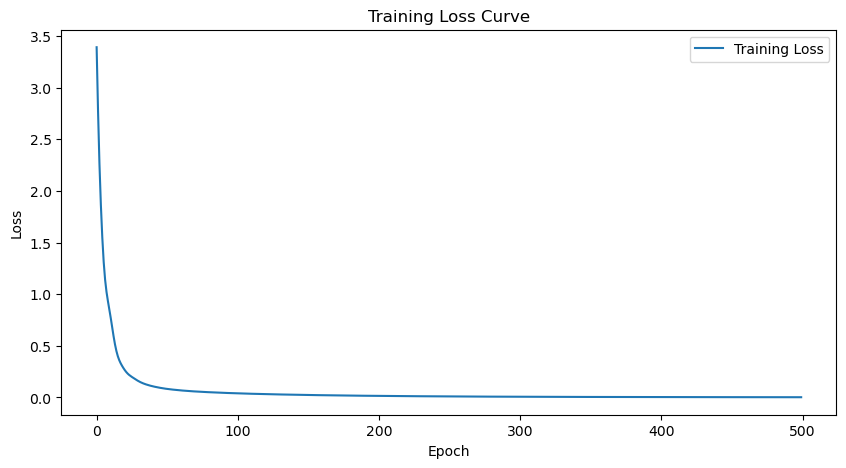

Final Model Accuracy: 88.64%


In [42]:
input_dim = X_train.shape[1]
hidden_dim = 256 
print(f"Training MLP model with input_dim={input_dim} and hidden_dim={hidden_dim}")

custom_mlp, losses, best_accuracy = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [43]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_layer_test.pth'.


In [44]:
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

                  precision    recall  f1-score   support

    infringement       0.85      0.93      0.89       283
non_infringement       0.92      0.85      0.88       298

        accuracy                           0.89       581
       macro avg       0.89      0.89      0.89       581
    weighted avg       0.89      0.89      0.89       581



/tmp/ipykernel_3740431/2137335780.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
